The cell below is importing libraries to be used.

In [39]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams

Next, we import the image and convert to native byte order for SEP

In [40]:
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

with fits.open("hubble105.fits") as hdul:
    data = hdul[0].data

# Convert to proper format for SEP later (does NOT change image content)
data = np.ascontiguousarray(data, dtype=np.float32)

Next, we display the image as is

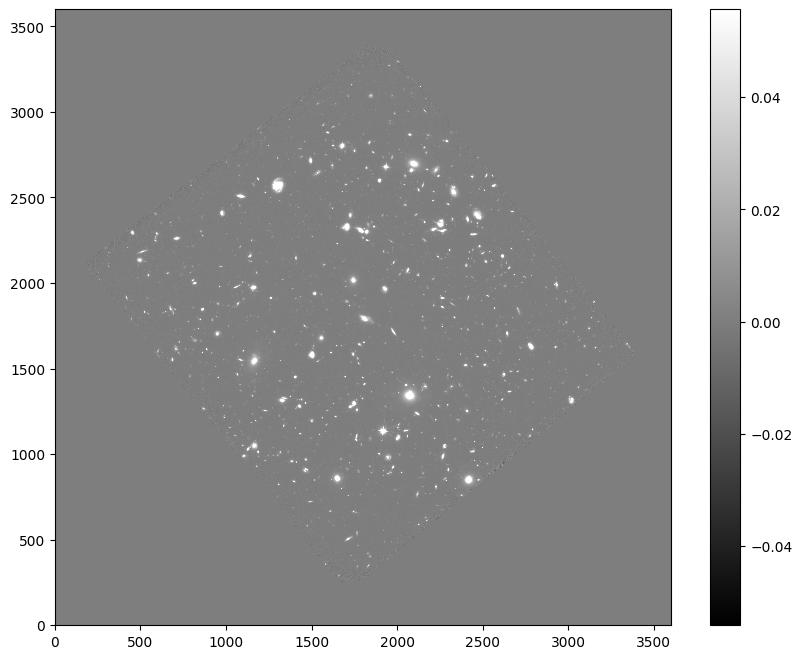

In [41]:
m, s = np.mean(data), np.std(data)

plt.imshow(data, interpolation='nearest',
           cmap='gray',
           vmin=m-s,
           vmax=m+s,
           origin='lower')

plt.colorbar()
plt.savefig("data2.png")
plt.show()

Next, we estimate the background, and then subtract it

In [42]:
bkg = sep.Background(data)

print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


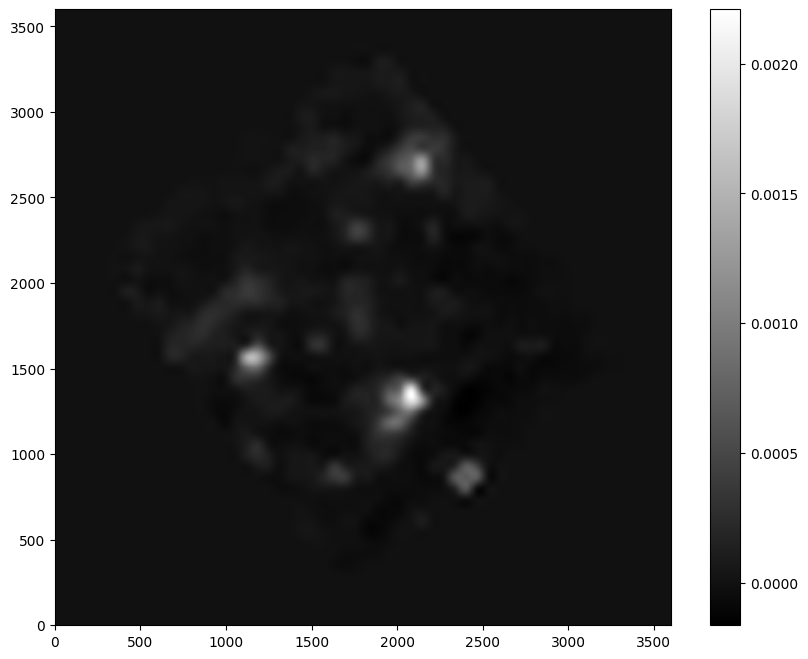

In [43]:
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest',
           cmap='gray',
           origin='lower')
plt.colorbar()
plt.savefig("background2.png")
plt.show()

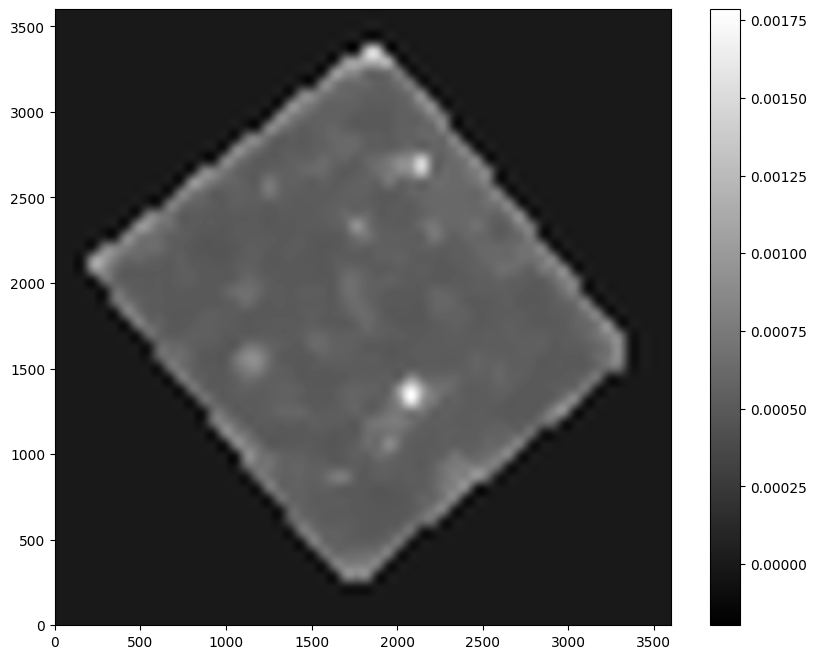

In [44]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest',
           cmap='gray',
           origin='lower')
plt.colorbar()
plt.savefig("backgroundNoise2.png")
plt.show()


In [45]:
data_sub = data - bkg

Now we extract the objects, and plot them

In [46]:
objects = sep.extract(data_sub, thresh=1.5, err=bkg.globalrms)

print("Number of objects detected:", len(objects))

Number of objects detected: 8640


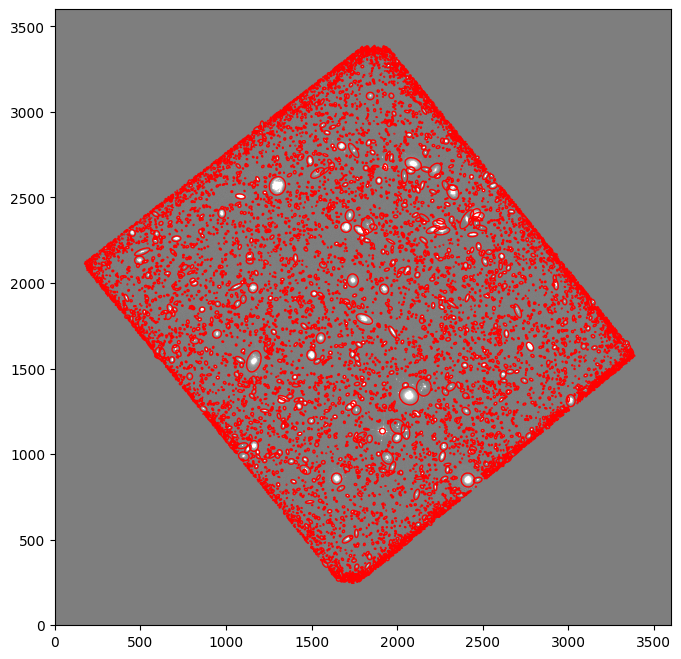

In [47]:
from matplotlib.patches import Ellipse

# Plot background-subtracted image with proper scaling
fig, ax = plt.subplots()

m, s = np.mean(data_sub), np.std(data_sub)

ax.imshow(data_sub,
          interpolation='nearest',
          cmap='gray',
          vmin=m - s,
          vmax=m + s,
          origin='lower')

# Plot ellipses
for i in range(len(objects)):
    e = Ellipse(
        xy=(objects['x'][i], objects['y'][i]),
        width=6 * objects['a'][i],
        height=6 * objects['b'][i],
        angle=objects['theta'][i] * 180. / np.pi
    )
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("objects2.png")
plt.show()

Next, we make a table of the first 10 objects in the list after performing simple circular aperture photometry with a 3 pixel radius at the object locations

In [48]:
flux, fluxerr, flag = sep.sum_circle(
    data_sub,
    objects['x'],
    objects['y'],
    3.0,
    err=bkg.globalrms,
    gain=1.0
)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


Next, we histogram the source fluxes

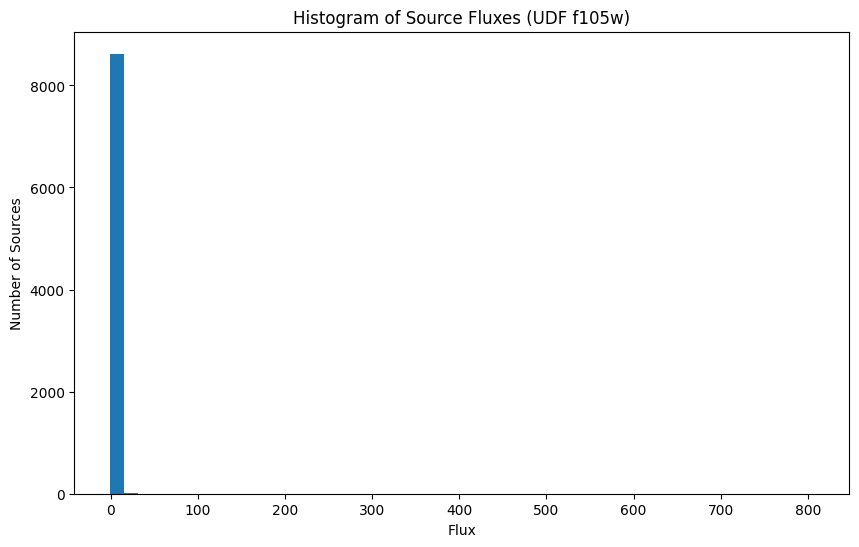

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(flux, bins=50)
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.title("Histogram of Source Fluxes (UDF f105w)")
plt.show()

Due to the number of incredibly faint sources, the histogram is skewed (skewed might be an understatement). Below is a histogram that accounts for that using a log-scale view

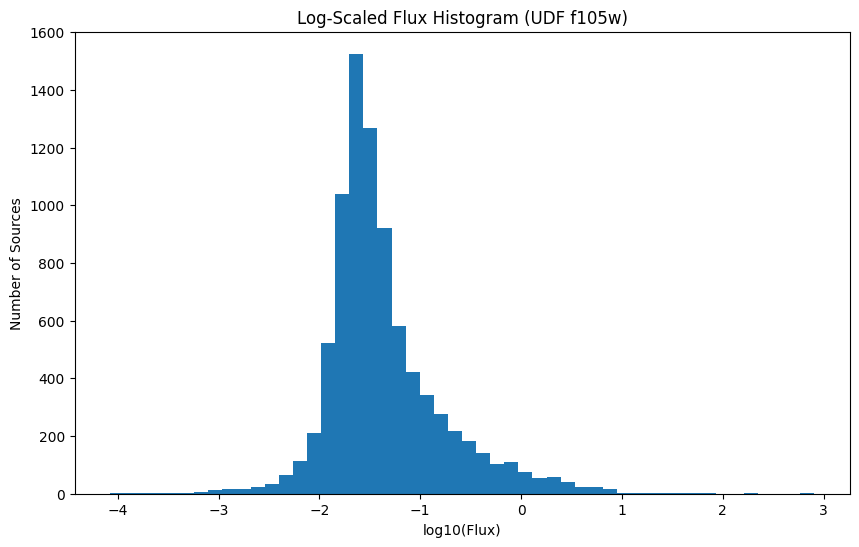

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(np.log10(flux[flux > 0]), bins=50)
plt.xlabel("log10(Flux)")
plt.ylabel("Number of Sources")
plt.title("Log-Scaled Flux Histogram (UDF f105w)")
plt.show()

Next, we find the mean, median, and standard deviation of the flux distribution. Then, the largest outlier, its location on the image, and the number of standard deviations it lies away from the mean

In [51]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print("Mean flux:", mean_flux)
print("Median flux:", median_flux)
print("Standard deviation:", std_flux)

Mean flux: 0.36186200072018937
Median flux: 0.03095655805023853
Standard deviation: 9.24352784277779


In [52]:
max_flux = np.max(flux)
max_index = np.argmax(flux)

print("Largest flux (outlier):", max_flux)

Largest flux (outlier): 807.2972835731507


In [53]:
x_outlier = objects['x'][max_index]
y_outlier = objects['y'][max_index]

print("Outlier position:")
print("x =", x_outlier)
print("y =", y_outlier)

Outlier position:
x = 1914.2549094866436
y = 1134.3164850725645


In [54]:
z_score = (max_flux - mean_flux) / std_flux
print("Outlier is", z_score, "standard deviations above the mean")

Outlier is 87.29734310292692 standard deviations above the mean


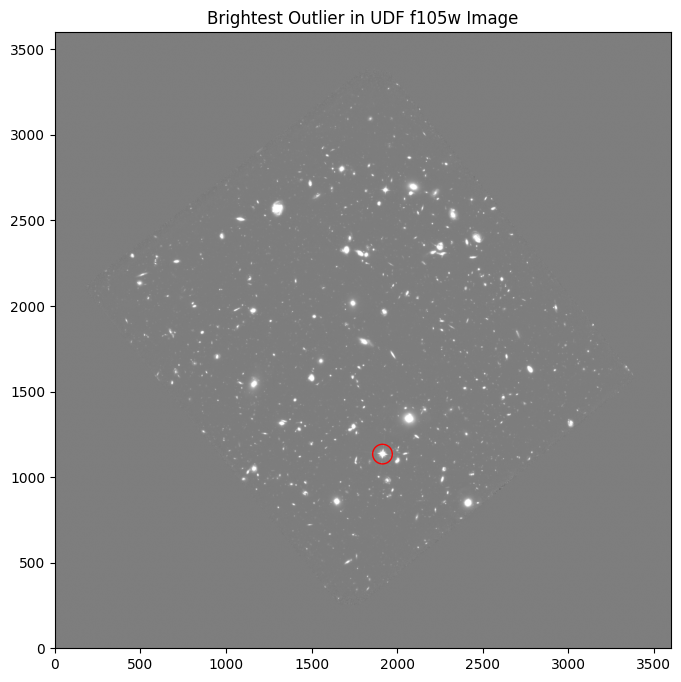

In [55]:
plt.figure(figsize=(8, 8))
m, s = np.mean(data_sub), np.std(data_sub)

plt.imshow(data_sub, cmap='gray',
           vmin=m-s, vmax=m+s,
           origin='lower')

plt.scatter(x_outlier, y_outlier,
            s=200, facecolors='none', edgecolors='red')

plt.title("Brightest Outlier in UDF f105w Image")
plt.savefig("outlierGraph.png")
plt.show()

Lastly, we make a 3-color false image of the UDF using RGB -> f160, f125, and f105

NOTE - Changed the names of the hubble data files to make them more readable

In [56]:
with fits.open("hubble105.fits") as hdu:
    img_b = hdu[0].data   # Blue
#re-opening this one as img_b instead of earlier 'data'
#to line up with other opened images

with fits.open("hubble125.fits") as hdu:
    img_g = hdu[0].data   # Green

with fits.open("hubble160.fits") as hdu:
    img_r = hdu[0].data   # Red

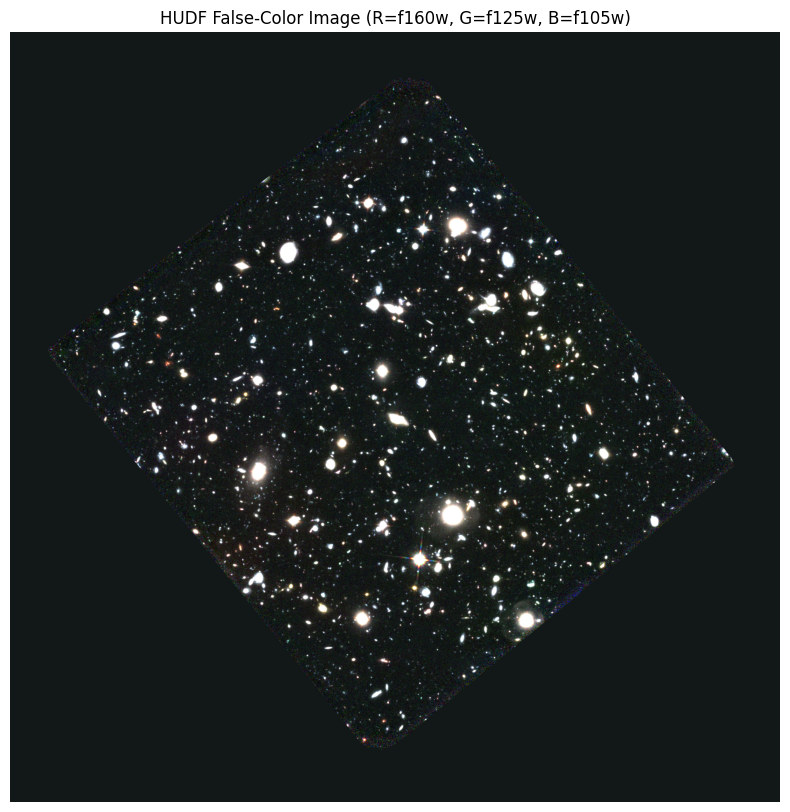

In [58]:
def normalize_percentile(img, pmin=1, pmax=99):
    img = np.nan_to_num(img)
    vmin, vmax = np.percentile(img, [pmin, pmax])
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin)
    return img

img_r_n = normalize_percentile(img_r)
img_g_n = normalize_percentile(img_g)
img_b_n = normalize_percentile(img_b)

rgb = np.dstack([img_r_n, img_g_n, img_b_n])

plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.title("HUDF False-Color Image (R=f160w, G=f125w, B=f105w)")
plt.savefig("hudf_rgb.png", dpi=300, bbox_inches='tight')
plt.show()

Final note - The above figure is gorgeous